In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename)

C:\Users\Matthew\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

train_df = trainid_df.join(properties_df)

In [4]:
# Try diffusing when propertylandusetypeid is 261.0 and when it is not.

vals_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
vals_df = vals_df.dropna()

vals_df['abslogerror'] = np.abs(vals_df.logerror.values)

In [5]:
# Define simple gradient descent for linear fit.

def l1linearfit(X, y, niterations, rate):
    npoints, nvars = X.shape
    coefficients = np.zeros(nvars)
    errors = []
    for i in range(niterations):
        grad = np.zeros(X.shape)
        ypredict = np.dot(X, coefficients.T)
        error = ypredict - y
        
        # Get grad update matrix
        # First the positive ones
        grad[error >= 0] = X[error >= 0]
        grad[error < 0] = -1 * X[error < 0]
        
        grad = np.sum(grad, axis = 0)
        coefficients -= grad * rate
        
        error = np.abs(error)
        error = np.mean(error)
        errors.append(error)
        
    return coefficients, errors

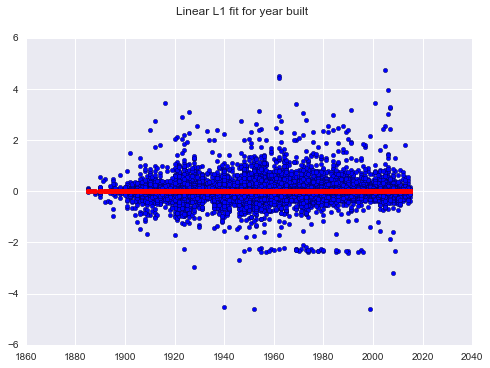

0.067578007794066863

In [6]:
# Let's get a benchmark of using just yearbuilt by looking at linear fit minimizing the L1 norm.

X = vals_df.yearbuilt.values.reshape(-1,1)
npoints, nvars = X.shape
X = np.hstack((X, np.full((npoints, 1), 1.0)))

y = vals_df.logerror.values

coeffs, errors = l1linearfit(X, y, 50, 10**-13)
ypredict = np.dot(X, coeffs.T)

plt.scatter(vals_df.yearbuilt, y)
plt.scatter(vals_df.yearbuilt, ypredict, color = 'red')
plt.suptitle('Linear L1 fit for year built')
plt.show()

abserror = np.abs(ypredict - y)
abserror = np.mean(abserror)
abserror

In [7]:
# Let's benchmark the percentage change in original error. That is, assuming the Zillow model is correct.

origerror = np.abs(vals_df.logerror)
origerror = np.mean(origerror)

(abserror - origerror) / origerror

-0.0047201299480441796

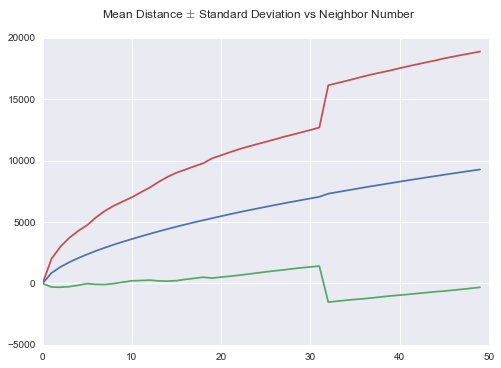

In [8]:
# Get an idea of how large the distances are for up to 50 neighbors
nbrs = NearestNeighbors(50)
nbrs.fit(vals_df[['latitude', 'longitude']])
points = vals_df[['latitude', 'longitude']]
distances, indices = nbrs.kneighbors(points)
meandist = np.mean(distances, axis = 0)
stddist = np.std(distances, axis = 0)

plt.plot(meandist)
plt.plot(meandist - stddist)
plt.plot(meandist + stddist)
plt.suptitle('Mean Distance $\pm$ Standard Deviation vs Neighbor Number')
plt.show()

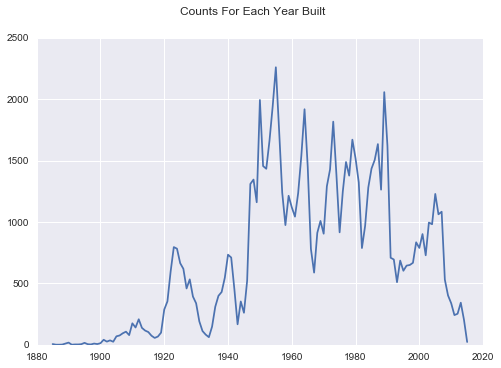

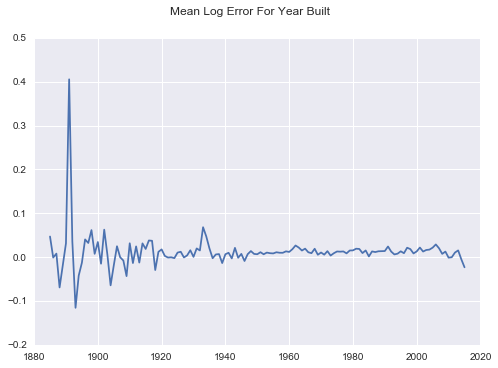

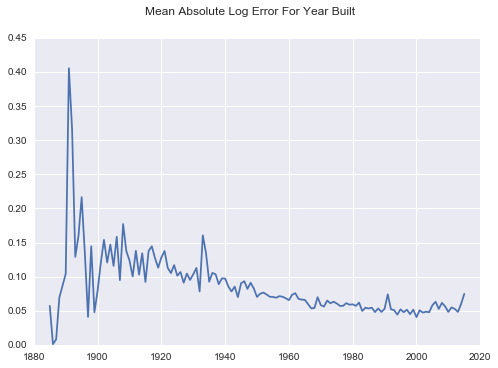

In [9]:
# Let's investigate diffusing the year built.

grouped_df = vals_df.groupby('yearbuilt').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.suptitle('Counts For Each Year Built')
plt.show()

grouped_df = vals_df.groupby('yearbuilt').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.suptitle('Mean Log Error For Year Built')
plt.show()

plt.plot(grouped_df.index, grouped_df.abslogerror)
plt.suptitle('Mean Absolute Log Error For Year Built')
plt.show()

In [10]:
# Get a graph of smallest L1 norm for L1 linear fit of diffusion as func of num neighbors to use in diffusion.

niterations = 80     # Number of iterations to do gradient descent on L1 norm.
learningrate = 10**-14     # Scaling factor for gradient descent.

diffinit = vals_df.yearbuilt.values.T     # Initial values of diffusions
coords = vals_df[['latitude', 'longitude']].values    # Coords for diffusions
diffusions = np.zeros(diffinit.shape)     # Will hold the actual value of the diffusions.

ks = range(1, 19, 2)     # Different possibilities of numbers of neighbors.
epsilons = np.arange(4, 6, 0.5)
epsilons = 10**epsilons # Possible epsilons to use in average weighting.
nbrs = NearestNeighbors()
nbrs.fit(coords)

errors = np.zeros((len(ks), len(epsilons)))

for i in range(len(ks)):
    k = ks[i]
    
    nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
    nbrdiffusions = diffinit[nbrindex]
    
    for j in range(len(epsilons)):
        epsilon = epsilons[j]
        
        weights = nbrdistance + epsilon
        weights = 1.0 / weights
        meandiffusions = weights * nbrdiffusions
        meandiffusions = np.sum(meandiffusions, axis = 1)
        meandiffusions /= np.sum(weights, axis = 1)
        diffusions = meandiffusions
        
        X = diffusions.reshape(-1,1)
        npoints, nvars = X.shape
        X = np.hstack((X, np.full((npoints, 1), 1.0)))
        y = vals_df.logerror.values.T
        coeffs, unusederrors = l1linearfit(X, y, niterations, learningrate)
        ypredict = np.dot(X, coeffs.T)
        
        abserror = np.abs(ypredict - y)
        abserror = np.mean(abserror)
        errors[i, j] = abserror
    
errors = errors.T    # Each row is for a specific epsilon.

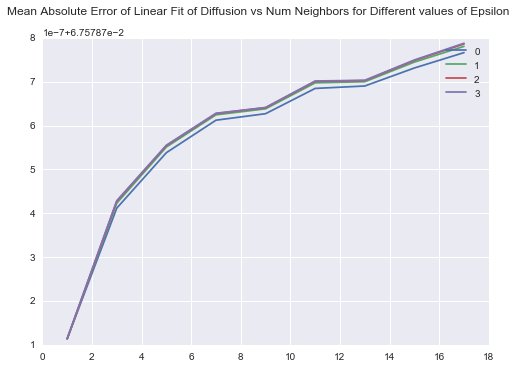

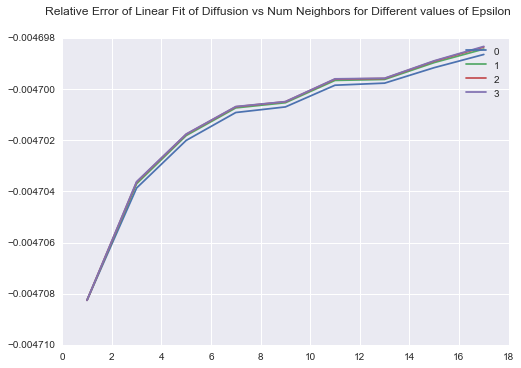

In [11]:
# Look at graphs of errors

nepsilon, nks = errors.shape

curves = []
names = [str(i) for i in range(nepsilon)]

for i in range(nepsilon):
    curve, = plt.plot(ks, errors[i])
    curves.append(curve)
plt.legend(curves, names)
plt.suptitle('Mean Absolute Error of Linear Fit of Diffusion vs Num Neighbors for Different values of Epsilon')
plt.show()

relerror = (errors - origerror) / origerror
for i in range(nepsilon):
    curve, = plt.plot(ks, relerror[i])
    curves.append(curve)
plt.legend(curves, names)
plt.suptitle('Relative Error of Linear Fit of Diffusion vs Num Neighbors for Different values of Epsilon')
plt.show()

In [33]:
def getpiecewiseconstant(X, nintervals = 10):
    maxval = np.amax(X)
    minval = np.amin(X)
    dval = (maxval - minval) / nintervals
    X2 = X.copy()
    for left in np.arange(minval+dval, maxval, dval):
        newcol = X.copy()
        newcol[X <= left] = 0.0
        X2 = np.hstack((X2, newcol))
    return X2

def getpiecewiseconstant(X, nintervals = 10):
    nrows, ncols = X.shape
    maxval = np.amax(X, axis = 0)
    minval = np.amin(X, axis = 0)
    dval = (maxval - minval) / nintervals
    X2 = np.full(X.shape, 1.0)
    vals = minval.copy()
    vals[0] += dval[0]

    while vals[ncols-1] <= maxval[ncols-1]:
        
        indices = X[:,0] < vals[0]
        for i in range(1, ncols):
            indices = indices & (X[:,i] < vals[i])
            
        newcols = X.copy()
        newcols[indices] = np.zeros(ncols)
        newcols[~indices] = np.full(ncols, 1.0)
        X2 = np.hstack((X2, newcols))
        
        vals[0] += dval[0]
        for i in range(ncols - 1):
            if vals[i] >= maxval[i]:
                vals[i] = minval[i]
                vals[i+1] += dval[i+1]
                
    return X2
        

(6, 2)
[ 100.  200.]


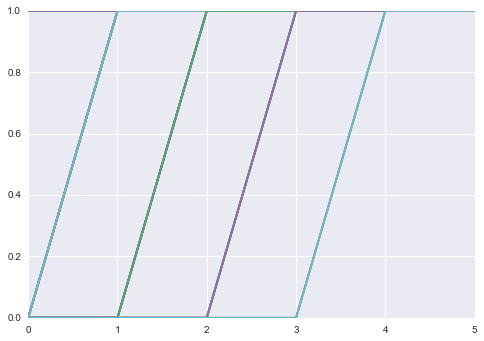

(60, 6)

In [34]:
# Test out piecewise constant function.

X = np.arange(0.0, 120.0, 20.0).reshape(-1,1)
X = np.hstack((X,X+100.0))
print(X.shape)
print(np.amax(X, axis = 0))
X = getpiecewiseconstant(X, nintervals = 5).T
nrows, ncols = X.shape
for row in range(nrows):
    plt.plot(X[row])
    
plt.show()

X.shape

In [92]:
# Let's look at a benchmark of piecewise constant fit of just year built.
nintervals = 5

X = vals_df.yearbuilt.values.reshape(-1,1)
X = getpiecewiseconstant(X, nintervals = nintervals)
y = vals_df.logerror.values
coeffs, errors = l1linearfit(X, y, 120, 10**-7)

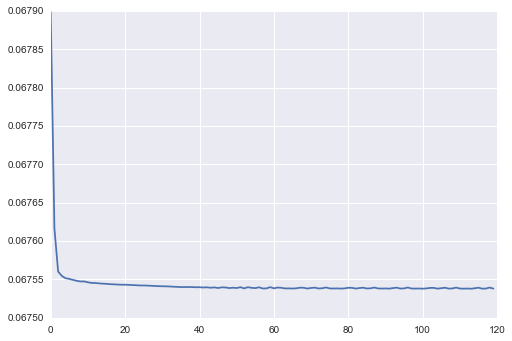

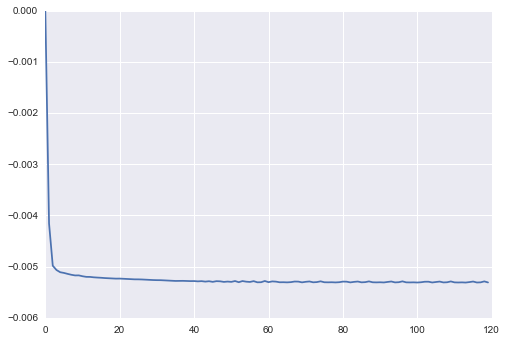

-0.0053108090321921505

In [93]:
# Plot outputs of benchmark

plt.plot(errors)
plt.show()

relerrors = (errors - origerror) / origerror
plt.plot(relerrors)
plt.show()

np.amin(relerrors)

In [90]:
# Now let's create benchmark for piecewise constant for yearbuilt appearing twice.
nintervals = 6

X1 = vals_df.yearbuilt.values.reshape(-1,1).copy()
X2 = X1.copy()
X = np.hstack((X1, X2))
print(X.shape)
X = getpiecewiseconstant(X, nintervals = nintervals)
print(X.shape)
y = vals_df.logerror.values
coeffs, errors = l1linearfit(X, y, 120, 10**-8)

(89519, 2)
(89519, 72)


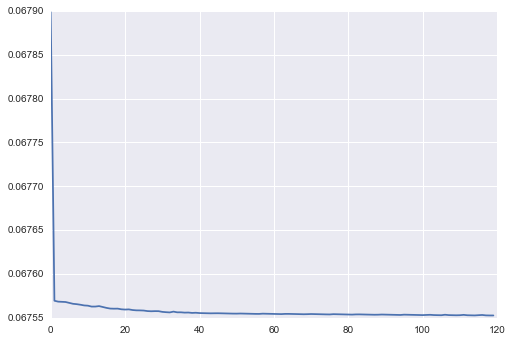

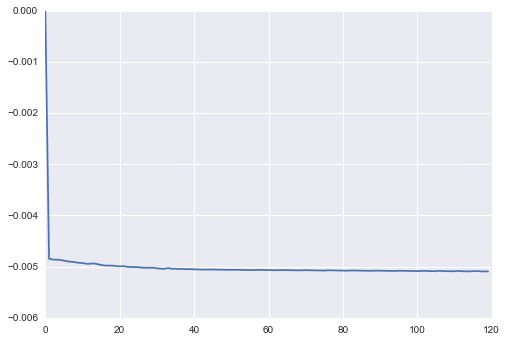

(89519, 72)


-0.0050933316701234814

In [91]:
# Plot outputs of benchmark

plt.plot(errors)
plt.show()

relerrors = (errors - origerror) / origerror
plt.plot(relerrors)
plt.show()

print(X.shape)
np.amin(relerrors)

In [73]:
# Set up diffusions for specific choice of neighbors and epsilon.

k = 10
epsilon = 10**5

nbrs = NearestNeighbors()
nbrs.fit(coords)

nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
nbrdiffusions = diffinit[nbrindex]
                         
weights = nbrdistance + epsilon
weights = 1.0 / weights
meandiffusions = weights * nbrdiffusions
meandiffusions = np.sum(meandiffusions, axis = 1)
meandiffusions /= np.sum(weights, axis = 1)
diffusions = meandiffusions

print(diffusions.shape)
vals_df['diffusions'] = diffusions

(89519,)


In [88]:
# Now let's try piecewise constant for yearbuilt and diffusions.
nintervals = 6

X1 = vals_df.yearbuilt.values.reshape(-1,1).copy()
X2 = vals_df.diffusions.values.reshape(-1,1).copy()
X = np.hstack((X1, X2))
print(X.shape)
X = getpiecewiseconstant(X, nintervals = nintervals)
print(X.shape)
y = vals_df.logerror.values
coeffs, errors = l1linearfit(X, y, 120, 10**-8)

(89519, 2)
(89519, 72)


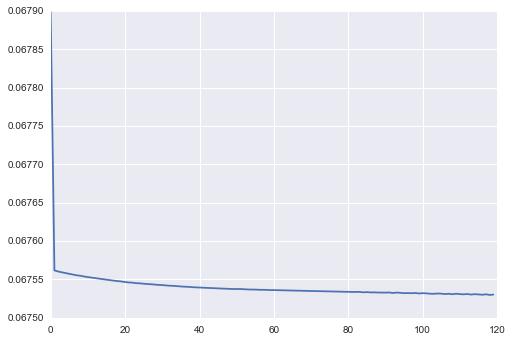

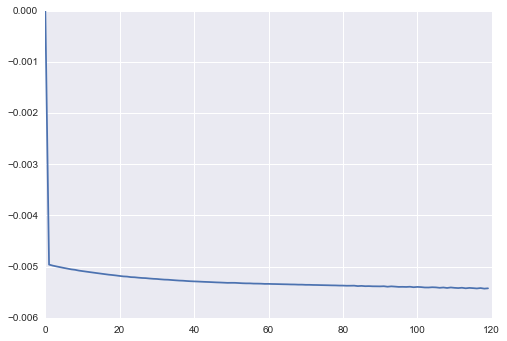

(89519, 72)


-0.0054295951884223044

In [89]:
# Plot outputs of benchmark

plt.plot(errors)
plt.show()

relerrors = (errors - origerror) / origerror
plt.plot(relerrors)
plt.show()

print(X.shape)
np.amin(relerrors)

In [98]:
# Now let's try a linear fit of averages for using many different numbers of neighbors.

ks = range(10, 50, 5)
epsilon = 10**5
X = vals_df.yearbuilt.values.reshape(-1,1)
X = np.hstack((X, np.full(X.shape, 1.0)))

nbrs = NearestNeighbors()
nbrs.fit(coords)

for k in ks:
    
    nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
    nbrdiffusions = diffinit[nbrindex]
                         
    weights = nbrdistance + epsilon
    weights = 1.0 / weights
    meandiffusions = weights * nbrdiffusions
    meandiffusions = np.sum(meandiffusions, axis = 1)
    meandiffusions /= np.sum(weights, axis = 1)
    diffusions = meandiffusions.reshape(-1,1)
    
    X = np.hstack((X, diffusions))
    
print(X.shape)

y = vals_df.logerror.values
coeffs, errors = l1linearfit(X, y, 80, 10**-14)
coeffs

(89519, 10)


array([  3.48294800e-07,   1.50540000e-10,   3.36633702e-07,
         3.34902735e-07,   3.33284078e-07,   3.32233386e-07,
         3.31709180e-07,   3.31556536e-07,   3.31535839e-07,
         3.31299122e-07])

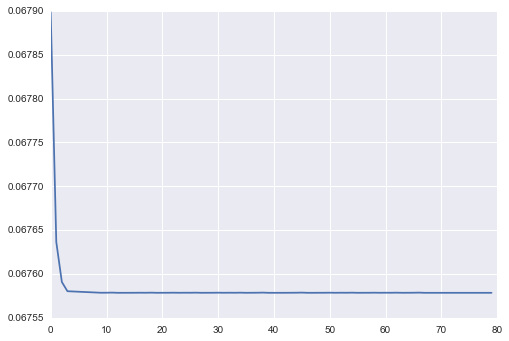

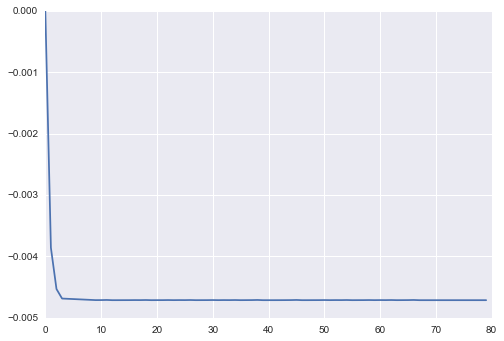

(89519, 10)


-0.004712863702018664

In [99]:
# Plot outputs of benchmark

plt.plot(errors)
plt.show()

relerrors = (errors - origerror) / origerror
plt.plot(relerrors)
plt.show()

print(X.shape)
np.amin(relerrors)